# Table 1

In [2]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements
from Utils.bar_utils import BarRenderer

### Loading and preprocessing data

In [3]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions

group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)


def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))
data.head(2)

Loading data from /Users/edgar/Repositorios/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...
Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


,source,treatment,group,round,player,score,threshold,num_players,decision,model,session
0,humans,score + grid,0001,0,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50,1
1,humans,score + grid,0001,0,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50,1


In [4]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions
    
group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)

def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))

Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


In [6]:
measurements_file = PATHS['human_data'] / Path('human_measurements.csv')
df = pd.read_csv(measurements_file)
df.head(2)

,model,treatment,threshold,num_players,group,session,efficiency,bounded_efficiency,inequality,bounded_inequality,entropy,conditional_entropy,conditional_entropy_2nd_order,min_entropy
0,11-8-0.38,downwards,0.375,8,11,3,-0.081731,-0.217949,0.109632,0.292353,0.583701,0.02,0.0,0.0
1,11-8-0.62,downwards,0.625,8,11,2,0.081731,0.130769,0.138580,0.221728,0.553701,0.05,0.0,0.0


In [7]:
# Find coordination type
# alt_index = AlternationIndex.from_file(priority='sklearn')
alt_index = AlternationIndex.from_file(priority='mlp')
df['predicted_class'] = alt_index.classify(df)

In [8]:
df.sort_values(by=['bounded_efficiency'], ascending=False, inplace=True)
sessions = np.array(df['model'].unique())
print(f"Number of sessions:", len(sessions))

Number of sessions: 99


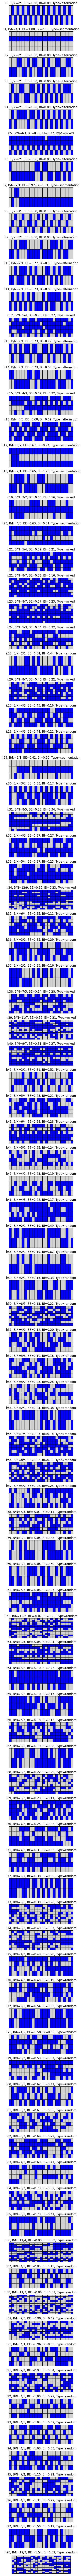

In [10]:
sessions_ = sessions#[:10]

fig, axes = plt.subplots(
    len(sessions_), 1, 
    figsize=(4, len(sessions_)*1.5),
    tight_layout=True
)

n_players = []
classifications = []

for i, session in enumerate(sessions_):
    df_aux = df[df['model'] == session]
    df_aux_aux = data[data['model'] == session]
    threshold = df_aux['threshold'].unique()[0]
    BE = df_aux['bounded_efficiency'].unique()[0]
    BI = df_aux['bounded_inequality'].unique()[0]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    classification = df_aux['predicted_class'].values[0]

    n_players.append(N)
    classifications.append(classification)

    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[i],
        title=f"i:{i}, B/N={N}/{B}, BE={BE:.2f}, BI={BI:.2f}, Type={classification}",
        num_rounds=25
    )

df_aux = pd.DataFrame({
    'num_players': n_players,
    'classification': classifications
})

plt.show()

df_aux.loc[0, 'classification'] = 'mixed'
df_aux.loc[1, 'classification'] = 'mixed'
df_aux.loc[2, 'classification'] = 'mixed'
df_aux.loc[4, 'classification'] = 'mixed'
df_aux.loc[5, 'classification'] = 'mixed'
df_aux.loc[11, 'classification'] = 'mixed'
df_aux.loc[35, 'classification'] = 'mixed'
df_aux.loc[39, 'classification'] = 'alternation'
df_aux.loc[48, 'classification'] = 'alternation'
df_aux.loc[60, 'classification'] = 'mixed'
df_aux.loc[61, 'classification'] = 'mixed'
df_aux.loc[72, 'classification'] = 'mixed'
df_aux.loc[86, 'classification'] = 'alternation'
df_aux.loc[95, 'classification'] = 'random'

In [11]:
df_aux['classification'].value_counts(normalize=True)

classification
random          0.676768
mixed           0.141414
alternation     0.121212
segmentation    0.060606
Name: proportion, dtype: float64

In [12]:
props_coord_classes = df_aux.groupby(['num_players'])['classification'].value_counts(normalize=True).reset_index()
props_coord_classes

,num_players,classification,proportion
0,2,random,0.478261
1,2,alternation,0.434783
2,2,segmentation,0.086957
3,3,random,0.666667
4,3,segmentation,0.166667
5,3,alternation,0.083333
6,3,mixed,0.083333
7,4,random,0.791667
8,4,mixed,0.083333
9,4,segmentation,0.083333


In [13]:
pivot_table = props_coord_classes.pivot(index='num_players', columns='classification', values='proportion').fillna(0)
pivot_table

classification,alternation,mixed,random,segmentation
num_players,,,,
2,0.434783,0.000000,0.478261,0.086957
3,0.083333,0.083333,0.666667,0.166667
4,0.041667,0.083333,0.791667,0.083333
5,0.000000,0.250000,0.750000,0.000000
6,0.000000,0.000000,1.000000,0.000000
7,0.000000,0.250000,0.750000,0.000000
8,0.000000,0.444444,0.555556,0.000000
9,0.000000,0.333333,0.666667,0.000000
11,0.000000,0.333333,0.666667,0.000000


In [ ]:
pivot_table.to_latex()